In [139]:
import numpy as np
import pandas as pd
import sympy as sp
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from scipy.constants import convert_temperature as conv_temp

# from Classes import LEDparams

# Simple PID library https://github.com/m-lundberg/simple-pid/tree/master (Documentation: https://pypi.org/project/simple-pid/)
from simple_pid import PID

from scipy.linalg import solve_discrete_are

In [140]:
class LEDparams:
    def __init__(self) -> None:
        self.I_LED = 0.017 # A
        
        # Identified at 0.017 A at 25°C
        radiant_power_dict = {
            'IR':       5.94,
            'Red':      1.70,
            'Orange':   1.18,
            'Green':    4.60,
            'Blue':     6.56,
            'Purple':   8.21,
            'UV':       3.92
        } # mW/cm^2

        # Convert to numpy array
        specific_radiant_power = np.array([radiant_power_dict[color] for color in radiant_power_dict.keys()]) # mW/cm^2

        # Single hole
        diameter = 6.7 # mm
        cross_section = np.pi * (diameter/10/2)**2 # cm^2
        self.radiant_power = cross_section * specific_radiant_power / 1000 # W

        # Dimensions for checking
        num_colors = len(specific_radiant_power)
        plate_row = 8
        plate_col = 12
        self.dimensions = (num_colors, plate_row, plate_col)

    def program_reader(self) -> np.ndarray:
        """ Returns the total duty cycle, single LED constant current and total radiant power"""
        x_matrix = np.random.randint(0, 2**16-1, self.dimensions) # TODO implement program reader
        x_matrix = x_matrix / 5 # TODO dcrease losses

        x_matrix_scaled = x_matrix / (2**16-1) # duty cycle

        self.P_r = np.sum(x_matrix_scaled * self.radiant_power[:, np.newaxis, np.newaxis]) # W

        self.x_LED_tot = np.sum(x_matrix_scaled) # total duty cycle assuming equal current for all LEDs

        return self.x_LED_tot, self.I_LED, self.P_r
    

class Model:
    def __init__(self, LEDparams:LEDparams, x0:np.ndarray, T_amb0:float=conv_temp(25.0, 'C', 'K')) -> None:
        """
        x0 : Initial state

        u1: current through the peltier module
        u2: PWM fan

        x1: SoC
        x2: T_HP_c
        x3: T_HP_h
        """
        # State input initialization
        self.x = x0
        self.u = np.array([0.0, 0.0])

        # Parameters initialization
        self._init_params(LEDparams, x0, T_amb0)

        # Dictionary to connect symbolic variables with values
        self.params_values = {
            'n_BT':         self.n_BT, # Battery
            'Q_max':        self.Q_BT_max,
            'R_in':         self.R_BT_int,
            'P_rest':       self.P_el_rest,
            'a3':           self.BT_coefs["a3"].iloc[0],
            'a2':           self.BT_coefs["a2"].iloc[0],
            'a1':           self.BT_coefs["a1"].iloc[0],
            'a0':           self.BT_coefs["a0"].iloc[0],
            'U_FAN':        self.U_FAN, # Fan
            'I_FAN':        self.I_FAN,
            'y_FAN':        self.FAN_coefs["y_min"].iloc[0],
            'a_FAN':        self.FAN_coefs["a"].iloc[0],
            'b_FAN':        self.FAN_coefs["b"].iloc[0],
            'k_FAN':        self.FAN_coefs["k"].iloc[0],
            'I_LED':        self.I_LED, # LED
            'x_LED':        self.x_LED,
            'P_r':          self.P_LED_r,
            'S_M':          self.S_M, # HP
            'R_M':          self.R_M,
            'K_M':          self.K_M,
            'cp_Al':        self.cp_Al, # Thermal
            'cp_w':         self.cp_H2O,
            'T_amb':        self.T_amb,
            'R3_lambda':    self.R_3_lambda,
            'm_c':          self.m_2 + self.m_4,
            'm_h':          self.m_1,
            'R_floor':      self.R_floor_lambda,
            'R4_lambda':    self.R_4_lambda,
            'R5':           self.R_5,
        }

        # Operational point initialization
        self._init_operational_point()

        # Symbolic initialization
        self._init_sym_model()

    def _init_params(self, LEDparams:LEDparams, x0:np.ndarray, T_amb0:float) -> None:
        """Assign parameters to the model
        T_amb0 : Ambient temperature in K
        """
        self.P_el_rest = 1.0 # W TODO get better value
        self.n_BT = 2
        self.Q_BT_max = 3.0 * 3600 # As (Ah = 3600 As)
        self.R_BT_int = 0.1 # Ohm
        self.BT_coefs = pd.read_csv(
            'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\Data\\Battery\\battery_fitted_coefficients_3rd.csv'
            )

        # Fan parameters
        self.I_FAN = 0.13 # A
        self.U_FAN = 12.0 # V
        self.FAN_coefs = pd.read_csv(
            'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\Data\\Fan\\fan_coefficients.csv'
            )

        # LED parameters
        self.I_LED = LEDparams.I_LED # A
        self.x_LED = LEDparams.x_LED_tot # duty cycle
        self.P_LED_r = LEDparams.P_r # W

        # Thermal parameters
        self.T_amb = T_amb0 # K
        self.cp_Al = 897.0 # J/kgK https://en.wikipedia.org/wiki/6061_aluminium_alloy
        self.cp_H2O = 4180.0 # J/kgK https://www.engineeringtoolbox.com/specific-heat-capacity-water-d_660.html
        # self.cp_air = 1006.0 # J/kgK https://www.engineeringtoolbox.com/air-specific-heat-capacity-d_705.html?vA=37&degree=C&pressure=1bar#

        # Top thermal parameters - Diffuser
        # TODO estimation of parameters
        self.R_3_lambda = 0.1 # K/W
        self.R_4_lambda = 0.5 # K/W
        self.R_5 = 25.0 # K/W

        # Top Al thermal parameters
        self.m_2 = 0.0638 # kg
        self.m_4 = 0.0642 # kg

        # Bottom Al thermal parameters - Heat sink
        self.m_1 = 0.0876 # kg
        self.R_floor_lambda = 2.6 # K/W # TODO estimated real time

        # Heat pump - peltier module
        HP_params = pd.read_csv(
            'C:\\Users\\giaco\\Git_Repositories\\Semester_Thesis_1\\Data\\Heat Pump\\HP_fitted_coefficients.csv'
            )
        self.I_HP_max = HP_params["I_max"].iloc[0] # A
        self.R_M = HP_params["R_M"].iloc[0] # Ohm
        self.S_M = HP_params["S_M"].iloc[0] # V/K
        self.K_M = HP_params["K_M"].iloc[0] # W/K

    def _init_operational_point(self) -> None:
        x_SoC = 0.85
        T_c   = conv_temp(self.T_amb, 'C', 'K') # K
        T_h   = conv_temp(self.T_amb + 30.0, 'C', 'K') # K
        I_HP  = 1.2 # A
        x_FAN = 1.0 # duty cycle

        self.x_op = np.array([x_SoC, T_c, T_h])
        self.u_op = np.array([I_HP, x_FAN])

    def _init_sym_model(self) -> None:
        # State variables
        x_SoC, T_c, T_h = sp.symbols('x_SoC, T_c, T_h')
        self.sym_x      = sp.Matrix([x_SoC, T_c, T_h])

        # Input variables
        I_HP, x_FAN = sp.symbols('I_HP, x_FAN')
        self.sym_u  = sp.Matrix([I_HP, x_FAN])

        # Battery parameters
        n, Q_max, R_in, P_rest = sp.symbols('n_BT, Q_max, R_in, P_rest')
        a3, a2, a1, a0 = sp.symbols('a3, a2, a1, a0')
        U_oc = a3 * x_SoC**3 + a2 * x_SoC**2 + a1 * x_SoC + a0
        # display(Markdown(r"$U_{oc}(x_{SoC}):$"), U_oc)
        # U_oc = 4 ############################

        # Fan parameters
        U_FAN, I_FAN = sp.symbols('U_FAN, I_FAN')
        y_min, a, b, k = sp.symbols('y_FAN, a_FAN, b_FAN, k_FAN')
        R_air_alpha = y_min + (1 / (x_FAN + a) + b - y_min) / (1 + sp.exp(-k * x_FAN))
        # display(Markdown(r"$R_{air}^\alpha(x_{FAN}):$"), R_air_alpha)
        # display(Markdown(r"$R_{air}^\alpha(x_{FAN}=1):$"), R_air_alpha.subs(self.params_values).subs({x_FAN: 1.0}))
        # display(Markdown(r"$R_{air}^\alpha(x_{FAN}=0):$"), R_air_alpha.subs(self.params_values).subs({x_FAN: 0.0}))
        # R_air_alpha = 1 ############################

        # LED parameters
        I_LED, x_LED, P_r = sp.symbols('I_LED, x_LED, P_r')

        # HP parameters - Peltier module
        S_M, R_M, K_M = sp.symbols('S_M, R_M, K_M')
        Q_c = S_M * I_HP * T_c - 0.5 * R_M * I_HP**2 - K_M * (T_h - T_c)
        # Q_c = 0 ############################

        # Thermal parameters
        cp_Al, T_amb = sp.symbols('cp_Al, T_amb')

        # Top thermal parameters - Diffuser
        R3_lambda = sp.symbols('R3_lambda')

        # Top Al thermal parameters - Diffuser
        m_c = sp.symbols('m_c')

        # Bottom Al thermal parameters - Heat sink
        m_h, R_floor_lambda = sp.symbols('m_h, R_floor')
        R_eq = (R_floor_lambda * R_air_alpha) / (R_floor_lambda + R_air_alpha)
        # display(Markdown(r"$R_{eq}(x_{FAN}=1):$"), R_eq.subs(self.params_values).subs({x_FAN: 1.0}))
        # display(Markdown(r"$R_{eq}(x_{FAN}=0):$"), R_eq.subs(self.params_values).subs({x_FAN: 0.0}))

        # Output: I_BT
        I_BT = U_oc + R_in * I_HP + R_in * I_LED * x_LED - sp.sqrt(U_oc**2 - 2 * R_in * I_LED * x_LED * U_oc - 2 * R_in * U_oc * I_HP + R_in**2 * I_HP**2 + 2 * R_in * I_LED * x_LED * R_in * I_HP - 4 * R_in * I_FAN * U_FAN * x_FAN - 4 * R_in * P_rest + (R_in * I_LED * x_LED)**2) # A
        U_BT = U_oc - R_in * I_BT # V

        # HP calculation
        U_HP = S_M * (T_h - T_c) + R_M * I_HP # V
        P_HP = U_HP * I_HP # W
        # P_HP = 0 ############################

        # LED calculation
        P_LED = I_LED * U_BT * x_LED # W
        Q_LED = P_LED - P_r # W
        # Q_LED = 0 ############################

        # Top thermal
        R4_lambda, R5 = sp.symbols('R4_lambda, R5')
        Q_LEDcell = (T_c - T_amb) / (R5 + R4_lambda) # W

        # Output: T_cell
        T_cell = R5 * Q_LEDcell + T_amb # K
        # display(Markdown(r"$T_{cell}:$"), T_cell.subs(self.params_values))

        # Nonlinear ODEs
        dTh_dt = (1 / (m_h * cp_Al)) * (Q_c + P_HP - (T_h - T_amb) / R_eq)
        dTc_dt = (1 / (m_c * cp_Al)) * (Q_LED - Q_LEDcell - Q_c)
        dxSoC_dt = - I_BT / (n * Q_max)

        # Symbolic dynamics, output and linearization
        self.f_symb = sp.Matrix([dxSoC_dt, dTc_dt, dTh_dt])
        self.g_symb = sp.Matrix([T_cell, I_BT])

        self.A_symb = self.f_symb.jacobian(self.sym_x)
        self.B_symb = self.f_symb.jacobian(self.sym_u)
        self.C_symb = self.g_symb.jacobian(self.sym_x)
        self.D_symb = self.g_symb.jacobian(self.sym_u)
        
        # Create numerical functions with parameters already inserted
        self.f_num = sp.lambdify((self.sym_x, self.sym_u), self.f_symb.subs(self.params_values), "numpy")
        self.g_num = sp.lambdify((self.sym_x, self.sym_u), self.g_symb.subs(self.params_values), "numpy")

        self.A_num = sp.lambdify((self.sym_x, self.sym_u), self.A_symb.subs(self.params_values), "numpy")
        self.B_num = sp.lambdify((self.sym_x, self.sym_u), self.B_symb.subs(self.params_values), "numpy")
        self.C_num = sp.lambdify((self.sym_x, self.sym_u), self.C_symb.subs(self.params_values), "numpy")
        self.D_num = sp.lambdify((self.sym_x, self.sym_u), self.D_symb.subs(self.params_values), "numpy")

    def get_linearization(self, xss:np.ndarray=None, uss:np.ndarray=None) -> np.ndarray:
        if xss is None:
            xss = self.x_op
        if uss is None:
            uss = self.u_op

        A = self.A_num(xss, uss)
        B = self.B_num(xss, uss)
        h = self.f_num(xss, uss)
        C = self.C_num(xss, uss)
        D = self.D_num(xss, uss)
        l = self.g_num(xss, uss)

        return np.array(A).astype(np.float32), np.array(B).astype(np.float32), np.array(h).astype(np.float32), np.array(C).astype(np.float32), np.array(D).astype(np.float32), np.array(l).astype(np.float32)
    
    def dynamics_f(self, x:np.ndarray, u:np.ndarray) -> np.ndarray:
        return np.array(self.f_num(x, u)).flatten()

    def observer_g(self, x:np.ndarray, u:np.ndarray) -> np.ndarray:
        return np.array(self.g_num(x, u)).flatten()

    def discretized_update(self, u:np.ndarray, dt:float) -> np.ndarray:
        """
        Update the states using Runge-Kutta of 4th order integration.
        """
        # Bound input
        u[0] = np.clip(u[0], -self.I_HP_max, self.I_HP_max)
        u[1] = np.clip(u[1], 0.0, 1.0)
        x = self.x

        # Runge-Kutta 4th order
        k = np.zeros((4, len(x)))
        k[0] = self.dynamics_f(x, u)
        k[1] = self.dynamics_f(x + 0.5 * dt * k[0], u)
        k[2] = self.dynamics_f(x + 0.5 * dt * k[1], u)
        k[3] = self.dynamics_f(x + dt * k[2], u)

        self.x = x + (dt / 6.0) * (k[0] + 2 * k[1] + 2 * k[2] + k[3])
        self.u = u

        # Bound SoC
        self.x[0] = np.clip(self.x[0], 0.0, 1.0)
        
        return self.x
    
    def get_output(self) -> np.ndarray:
        return self.observer_g(self.x, self.u)


class BasicController:
    def __init__(self) -> None:
        pass

    def get_control_input(self, current_output) -> np.ndarray:
        u_HP = 0.0
        u_FAN = 0.0
        return np.array([u_HP, u_FAN])
    

class PIDController:
    def __init__(self, kp:float, ki:float, kd:float, setpoint:float, dt:float, output_limits:tuple) -> None:
        self.pid = PID(Kp=kp, Ki=ki, Kd=kd, setpoint=setpoint, output_limits=output_limits)
        # self.pid = PID(Kp=kp, Ki=ki, Kd=kd, setpoint=setpoint, sample_time=dt, output_limits=output_limits)

    def get_control_input(self, current_output:float) -> np.ndarray:
        u_HP = self.pid(current_output)
        u_FAN = 1.0
        return np.array([u_HP, u_FAN])


class LQRController:
    """ Infinite horizon LQR controller """
    def __init__(self, A:np.ndarray, B:np.ndarray, Q:np.ndarray, R:np.ndarray) -> None:
        # Check dimensions of A, B, Q, R
        if A.shape[0] != A.shape[1]:
            raise ValueError("Matrix A must be square.")
        if B.shape[0] != A.shape[0]:
            raise ValueError("Matrix B must have the same number of rows as A.")
        if Q.shape != A.shape:
            raise ValueError("Matrix Q must have the same dimensions as A.")
        if R.shape[0] != R.shape[1] or R.shape[0] != B.shape[1]:
            raise ValueError("Matrix R must be square and match the number of columns of B.")

        # Check if Q and R are (semi)positive definite
        if not self.is_positive_definite(Q):
            raise ValueError("Matrix Q must be positive semi-definite.")
        if not self.is_positive_definite(R):
            raise ValueError("Matrix R must be positive definite.")
        
        # Check controllability and observability
        if not self.is_controllable(A, B):
            raise ValueError("The system is not controllable with the given A and B matrices.")
        
        if not self.is_observable(A, C):
            raise ValueError("The system is not observable with the given A and C matrices.")


        # Solve Riccati equation
        self.P = solve_discrete_are(A, B, Q, R)
        self.K = -np.linalg.inv(R + B.T @ self.P @ B) @ B.T @ self.P @ A

    def get_control_input(self, current_state) -> np.ndarray:
        return self.K @ current_state

    @staticmethod
    def is_positive_definite(X:np.ndarray) -> bool:
        try:
            # Attempt Cholesky decomposition to check positive definiteness
            np.linalg.cholesky(X)
            return True
        except np.linalg.LinAlgError:
            return False
        
    @staticmethod
    def is_controllable(A, B):
        n = A.shape[0]
        controllability_matrix = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])
        return np.linalg.matrix_rank(controllability_matrix) == n
    
    @staticmethod
    def is_observable(A, C):
        n = A.shape[0]
        observability_matrix = np.vstack([C @ np.linalg.matrix_power(A, i) for i in range(n)])
        return np.linalg.matrix_rank(observability_matrix) == n


class Simulation:
    def __init__(self, model, controller, dt, time_span) -> None:
        self.model = model
        self.controller = controller
        self.dt = dt
        self.time_span = time_span

    def run(self) -> pd.DataFrame:
        time_steps = int(self.time_span / self.dt)
        
        data = {
            "time":     [],
            "SoC":      [],
            "T_HP_c":   [],
            "T_HP_h":   [],
            "I_HP":     [],
            "x_FAN":    [],
            "T_cell":   [],
            "I_BT":     [],
        }

        for t in range(time_steps):
            current_time = t * self.dt

            # print(f"------------- {current_time} -------------")

            y = self.model.get_output()

            u = self.controller.get_control_input(y[0])

            # Advance system states
            x = self.model.discretized_update(u, self.dt)

            data["time"].append(current_time)
            data["SoC"].append(x[0])
            data["T_HP_c"].append(x[1])
            data["T_HP_h"].append(x[2])
            data["I_HP"].append(u[0])
            data["x_FAN"].append(u[1])
            data["T_cell"].append(y[0])
            data["I_BT"].append(y[1])

        return pd.DataFrame(data)

In [141]:
LEDpar = LEDparams()
LEDpar.program_reader()

# Initial conditions
T_amb0 = conv_temp(41.0, 'C', 'K') # K
x0 = np.array([0.9, T_amb0, T_amb0])

model = Model(LEDpar, x0, T_amb0=T_amb0)

dt_sim = 1 # s
time_span = 60 * 60 # s

assert time_span > 0, "Time span must be positive."
assert time_span >= dt_sim, "Time span must be greater than or equal to the time step."

dt_disc = 1.0 # s

kp, ki, kd = -1.0, -1.0, 0.0
setpoint = conv_temp(37.0, 'C', 'K') # K
output_limits = (-model.I_HP_max, model.I_HP_max) # A
controller = PIDController(kp, ki, kd, setpoint, dt_disc, output_limits)

A, B, h, C, D, l = model.get_linearization()
Q = np.eye(A.shape[0]) # C.T @ C
R = np.eye(B.shape[1])

sim = Simulation(model, controller, dt_sim, time_span)

# Run the simulation
results = sim.run()

# Conversion
results[["T_cell", "T_HP_c", "T_HP_h"]] = conv_temp(results[["T_cell", "T_HP_c", "T_HP_h"]].to_numpy(), 'K', 'C')

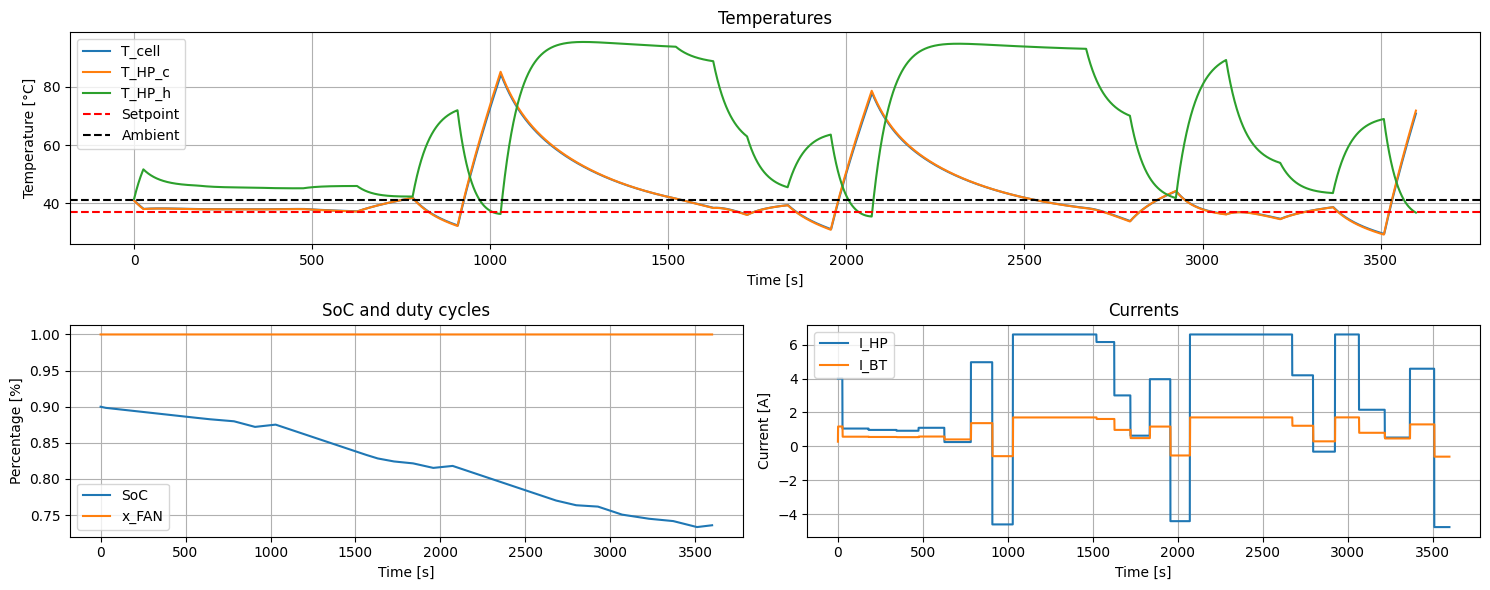

In [142]:
fig = plt.figure(figsize=(15, 6))

# Set up gridspec to span the temperature plot over 2 columns
gs = fig.add_gridspec(2, 2)

# Temperatures
ax0 = fig.add_subplot(gs[0, :])  # Span the first row across both columns
ax = results.plot(
    x="time", 
    y=["T_cell", "T_HP_c", "T_HP_h"], 
    xlabel="Time [s]", 
    ylabel="Temperature [°C]", 
    title="Temperatures",
    ax=ax0
)
ax.axhline(
    y=conv_temp(setpoint, 'K', 'C'), 
    color='r', 
    linestyle='--', 
    label='Setpoint'
)
ax.axhline(
    y=conv_temp(T_amb0, 'K', 'C'), 
    color='k', 
    linestyle='--', 
    label='Ambient'
)
ax.legend()
ax.grid()

# Soc and duty cycles
ax1 = fig.add_subplot(gs[1, 0])
ax = results.plot(
    x="time", 
    y=["SoC", "x_FAN"], 
    xlabel="Time [s]", 
    ylabel="Percentage [%]", 
    title="SoC and duty cycles",
    ax=ax1
)
ax.legend()
ax.grid()

# Currents
ax2 = fig.add_subplot(gs[1, 1])
ax = results.plot(
    x="time", 
    y=["I_HP", "I_BT"], 
    xlabel="Time [s]", 
    ylabel="Current [A]", 
    title="Currents",
    ax=ax2
)
ax.legend()
ax.grid()

# Adjust layout
plt.tight_layout()
plt.show()
